# Switch Analysis
##### David M. Freestone & Fuat Balci
March 14, 2016

### 1.0 Introduction

This jupyter notebook shows how to analyze the data collected using the Psychopy Switch experiment accompanying xxx (the chapter).

First, we need to tell Python what packages and functions we'll use in this analysis script. They come in the form of import statements

In [1]:
from glob import glob     # for finding data files
from os.path import join  # for dealing with path names easily
from ast import literal_eval # for converting a string of a list into a list

from pandas import read_csv, concat, isnull     # reading in the data
from scipy.stats import invgauss, expon, norm # useful distributions
from scipy.optimize import minimize     # gradient descent fitting
from numpy import array, arange, log, sqrt, hstack     # some math functions

from matplotlib.pyplot import subplots, style  # for plotting
style.use("fivethirtyeight")                   # set figure style

# Import entire packages, so we can explore later.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Needed so plots show up in the jupyter notebook
%matplotlib inline

# Matplotlib spits out an annoying FutureWarning that we don't care about.
# Suppress it
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

Next we define the data directory, find all the ".csv" files in the directory, and load them all into a pandas DataFrame

In [2]:
data_directory = "data"
data_files = glob(join(data_directory, "*.csv"))
data = concat([read_csv(f) for f in data_files])

There are a lot of columns in this dataset that we'll probably never use (i.e., frameRate). It makes looking at the data easier if we remove them.

We'll also remove any event that isn't a response (like the introduction and break screens).

In [3]:
columns = ["participant", "session", "date", "time", 
           "block_number", "interval", "trial_number", 
           "response", "response_time", "score",
           "p_short", "v_short", "v_long", "c_short", "c_long"]
trial_idx = data.trial_number > 0
data = data.ix[trial_idx, columns]

Pull out the task parameters

In [4]:
def task_parameters(data):
    """Return the task parameters from the dataframe into a tuple
        (to pass into functions more cleanly)
    """
    (v_short, v_long, 
     c_short, c_long,
     p_short) = data.iloc[0][["v_short", "v_long", "c_short", "c_long", "p_short"]]

    p_long = 1-p_short
    T_short, T_long = data.interval.min(), data.interval.max()

    return (T_short, T_long, p_short, p_long,
            v_short, v_long, c_short, c_long)

task_params = task_parameters(data)

##### 1.1 Switch times

The key datum in the analysis are the switch times per trial. For completeness, the Psychopy Switch task records every response, not just the time of the switch. So we have to get the time of the switch per trial.

There are a few things that can go wrong, though. For example, the participant could never switch by either pressing the short the entire time or pressing the long the entire time. Or, the participant can switch back to the short after already switching to the long. These cases may be interesting to study, but we'll remove them and only deal with "clean" trials.

In [5]:
def switch_time(df):
    """Return the switch time on a single trial"""
    short_times = df[df.response=="left"].response_time
    long_times = df[df.response=="right"].response_time
    
    if (short_times.size < 1) or (long_times.size < 1):
        # Didn't press one of the options, no switch
        return None
    elif short_times.max() > long_times.min():
        # switched back to short at some point, no switch
        return None
    return long_times.iloc[0]     

We get the switch times per subject, session, and trial, and only for long trials.

In [6]:
long_trials = data.interval == 3
group = ["participant", "session", "trial_number"]

data = (data[long_trials].groupby(group)
        .apply(switch_time)
        .pipe(pd.DataFrame)
        .rename(columns={0:"switch_time"})
        .reset_index()
        .dropna())

### 2.0 Summary measures

##### 2.1 Summary statistics

In [7]:
group = ["participant", "session"]
data.groupby(group).switch_time.describe()

participant  session       
DMF          1        count    17.000000
                      mean      2.477279
                      std       0.410282
                      min       1.436948
                      25%       2.339518
                      50%       2.639986
                      75%       2.691751
                      max       2.940278
             2        count    13.000000
                      mean      2.466760
                      std       0.261645
                      min       2.121079
                      25%       2.239262
                      50%       2.406715
                      75%       2.657226
                      max       2.957327
FB           1        count    20.000000
                      mean      2.413076
                      std       0.280987
                      min       1.872804
                      25%       2.184126
                      50%       2.456896
                      75%       2.595163
                      max    

In [8]:
data.groupby(group).switch_time.agg(["mean", "std", "sem"])

mean       std       sem
participant session                              
DMF         1        2.477279  0.410282  0.099508
            2        2.466760  0.261645  0.072567
FB          1        2.413076  0.280987  0.062831
            2        2.381595  0.453271  0.113318

##### 2.2 Scatter Plots

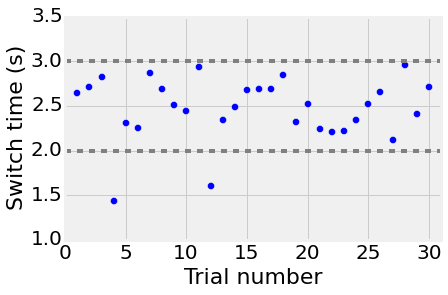

In [9]:
idx = data.participant=="DMF"
y = data[idx].switch_time
x = arange(1, y.size+1)

fig, ax = subplots()
ax.scatter(x, y, s=50)
ax.hlines([2, 3], [0]*2, [1+x.max()]*2,
          linestyle="--", color="gray")

# Modify the axes
ax.set_xlim((0, 1+x.max()))
ax.set_xlabel("Trial number", fontsize=22)
ax.set_ylabel("Switch time (s)", fontsize=22)
ax.tick_params(labelsize=20)

##### 2.3 Histograms

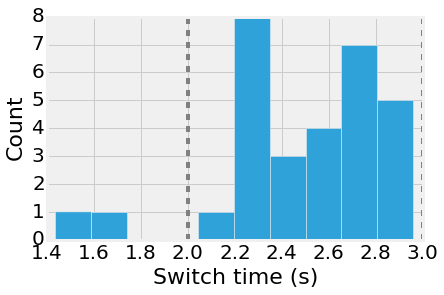

In [10]:
# Plot a histogram of the response times
ax = data[data.participant=="DMF"].switch_time.hist();

# plot a line at the DRL schedule
ymin, ymax = ax.get_ylim()
ax.vlines([2, 3], [ymin]*2, [ymax]*2, 
          linestyle="--", color="gray")

# Label the x and y axes, and change the tick label size
ax.set_xlabel("Switch time (s)", fontsize=22)
ax.set_ylabel("Count", fontsize=22)
ax.tick_params(labelsize=20)

### 3.0 Fitting the switch time distribution


In humans and rats, the switch times are normally distributed. In mice, they are sometimes a mixture distribution of an exponential and a Gaussian. The "DRL_Analysis" code shows how to fit a mixture distribution.

Since humans and rats show normally distributed switch times, the maximum likelihood estimates of the parameters are the mean and standard deviation.

In [11]:
# Can "fit" analytically since the parameters are μ=mean and σ=standard deviation
fit_results = data.groupby(["participant"]).switch_time.agg(["mean", "std"])
fit_results = fit_results.rename(columns={"mean": "μ", "std": "σ"})

# Throw in γ
fit_results["γ"] = fit_results.σ / fit_results.μ

##### 3.2 Visualizing the fits


(0, 4)

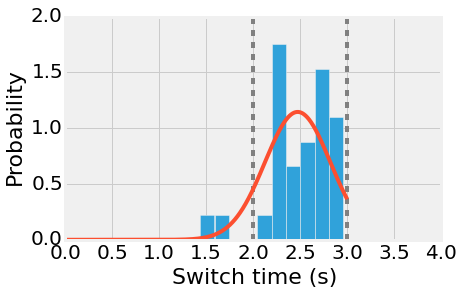

In [12]:
participant = "DMF"
# Pull out the parameters for one participant (and convert to a matrix)
params = fit_results.ix[participant, ["μ", "σ"]].as_matrix()

x = np.linspace(0, 3, 1000)

st = data[data.participant==participant].switch_time.as_matrix()
st_fit = norm.pdf(x, *params)

# Plot
fig, ax = subplots()
ax.vlines([2, 3], [0]*2, [2]*2, linestyle="--", color="gray")

ax.hist(st, bins=10, normed=True);
ax.plot(x, st_fit)

# Modify the axes
ax.set_xlabel("Switch time (s)", fontsize=22)
ax.set_ylabel("Probability", fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim((0, 4))

### 4.0 Assessing Optimality

We assume optimal behavior is to maximize the rewards per trial, again constrained by timing variability. In order to maximize reward, participants should switch at a time that best manages the tradeoff between (i) switching too early on short trials, (ii) switching too late on long trials, (iii) the probability of it being a short or long trial, (iv) the reward magnitudes and penalties associated with being correct on a short or long trial.

The probability of a short trial is set by the experimenter at $p(s)$. The reward magnitudes for being correct on a short or long trial is $v(s)$ and $v(\ell)$, respectively. The penalties are $c(s)$ and $c(\ell)$ ($c$ for $c$ost)

To minimize the errors (i and ii above), the participant should position his or her switches between the short and long durations. On short trials, this means the participant will have not yet switched by the short duration, and will earn the reward. On long trials, this means the participant will have already switched by the long duration, and will earn the reward. The probability of switching after the short duration is the fraction of switches that occur after the short duration. Assuming normally distributed switch times

$$p(t \ge s) = 1 - \Phi(s;\mu, \sigma)$$

where $\Phi(s; \mu, \sigma)$ is the cumulative normal distribution evaluated at the short interval when the parameters of the participants switches $\mu$ and $\sigma$. The probability of switching before the long duration is

$$p(t \le \ell) = \Phi(\ell;\mu, \sigma)$$

And the probability of switching too early or too late are the complements. This means the expected value for each possible switch time are the four possible outcomes weighted by their probability of occurance.

$$E[r] = v(s)p(s)p(t \ge s) + v(\ell)p(\ell)p(t \le \ell) + c(s)p(s)p(t<s) + c(\ell)p(\ell)p(t>\ell)$$

We'll use the weber's fraction as the measure of timing variability so that $\sigma = \gamma \mu$

In [13]:
def p_switchAfterShort(T, μ, γ):
    """Return the probability switching after the short duration"""
    return 1 - norm.cdf(T, μ, γ*μ)

def p_switchBeforeLong(T, μ, γ):
    """Return the probability of switching before the long duration"""
    return norm.cdf(T, μ, γ*μ)

def expected_reward(μ, γ, task_params):
    """Return the expected reward given μ and γ"""
    (T_short, T_long, p_short, p_long,
     v_short, v_long, c_short, c_long) = task_params
    
    return (  v_short*p_short*p_switchAfterShort(T_short, μ, γ)
            + v_long*p_long*p_switchBeforeLong(T_long, μ, γ)
            + c_short*p_short*(1-p_switchAfterShort(T_short, μ, γ))
            + c_long*p_long*(1-p_switchBeforeLong(T_long, μ, γ)))

The optimal rewards per trial depends on the participants choice of $\mu$, constrained by their estimate of their own variability, $\gamma$. The optimal switch time to have is the switch time $\mu$ that maximizes the expected reward:

$$\mathrm{argmax}_\mu E[r; \gamma]$$

The notation shows the dependence of $\gamma$. This equation gives the reward maximizing relationship between $\mu$ and $\gamma$. Because its a function of $\gamma$, the reward maximizing strategy is a infinite set of points that lay along an "optimal performance curve" ($OPC$).

In [14]:
def optimal(γ, task_params):
    """Return the optimal mean switch time given γ"""
    T_long = task_params[1]
    μ, γ = np.meshgrid(np.linspace(0, 1.5*T_long, 1000), γ)
    r = expected_reward(μ, γ, task_params)

    # When γ is very low (or zero), the expected value can't really be computed.
    idx = ~np.isnan(r).all(axis=1)
    γ = γ[idx, :]
    r = r[idx, :]
    return (μ[0, np.nanargmax(r, axis=1)], 
            np.nanmax(r, axis=1))

The expected reward grows as a function of $\mu$ because the probability that the participant switches after the short (thus earning reward on short trials) grows. But then the expected reward shrinks as a function of $\mu$ because the probability that the participants switches after the long (thus failing to earn a reward on long trials) grows. The reward maximizing strategy is to choose a mean switch time $\mu$ that best balances these errors, accounting for differential reward magnitudes, probabilities and costs.

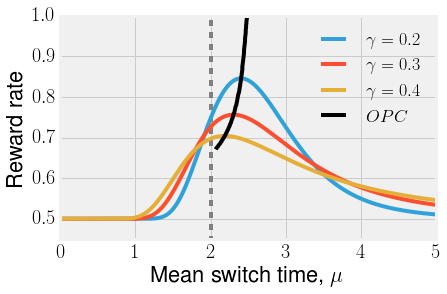

In [15]:
μ = np.linspace(0, 5, 1000)

plt.rc('text', usetex=True)
fig, ax = subplots()

ax.vlines(task_params[:1], [0]*2, [1]*2, linestyle="--", color="gray")

γp2 = expected_reward(μ, 0.2, task_params) # using it both to plot and for ylim computation
ax.plot(μ, γp2, label=r"$\gamma = 0.2$")
ax.plot(μ, expected_reward(μ, 0.3, task_params), label=r"$\gamma = 0.3$")
ax.plot(μ, expected_reward(μ, 0.4, task_params), label=r"$\gamma = 0.4$")

μ_opt, r_opt = optimal(np.linspace(0, 0.5, 100), task_params)
ax.plot(μ_opt, r_opt, color='k', label="$OPC$")

ax.set_ylim((0.9*np.nanmin(γp2), 1))
ax.legend(loc="best", fontsize=18, framealpha=0)
ax.set_xlabel("Mean switch time, $\mu$", fontsize=22)
ax.set_ylabel("Reward rate", fontsize=22)
ax.tick_params(labelsize=20)

##### 3.1 Are the participants optimal?

To assess the degree to which the participants are optimal, we have to find the optimal mean switch time per participant, and then compare it to their actual mean switch time.

In [16]:
γ = fit_results.γ.as_matrix()
μ = fit_results.μ.as_matrix()
r = expected_reward(μ, γ, task_params)

μ_opt, r_opt = optimal(γ, task_params)

distance_from_optimal = μ / μ_opt
proportion_maximum_gain = r / r_opt

Now plot these two measures over participants

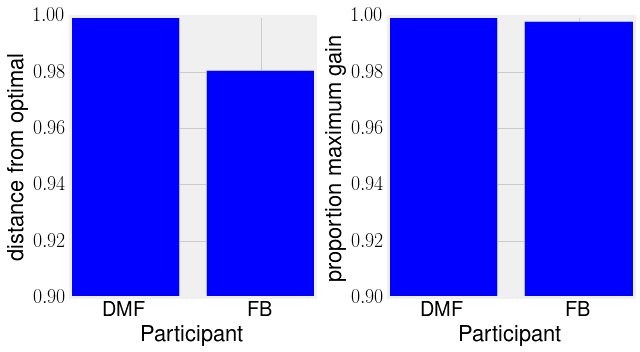

In [17]:
participants = fit_results.index.values
nparticipants = len(participants)

fig, ax = subplots(ncols=2, figsize=(9,5))
ax_dist, ax_prop = ax

# Plot the distance from optimal measure.
ax_dist.bar(range(0,nparticipants), distance_from_optimal, align="center");
ax_dist.set_ylabel("distance from optimal", fontsize=22)

# Plot the distance from optimal measure.
ax_prop.bar(range(0,nparticipants), proportion_maximum_gain, align="center");
ax_prop.set_ylabel("proportion maximum gain", fontsize=22)

# Mofidy both axes at the same time.
for a in ax:
    a.set_xticks(range(0, nparticipants))
    a.set_xticklabels(participants)
    a.set_ylim((0.9, 1))
    a.set_xlabel("Participant", fontsize=22)
    a.tick_params(labelsize=20)
fig.tight_layout()